# Dynamic scaLCA - combining dynamic material flow analysis with Life cycle assessment

## 1. Modules and Functions

### 1.1 Modules

In [1]:
import bw2data as bd
import bw2io as bi
from pathlib import Path
import bw2data as bd
import bw2calc as bc
import pandas as pd
import numpy as np
import scipy.stats
from os import chdir
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

### 1.2 Functions

In [8]:
def update_material_composition(secondary_steel_share):
    materials = {}
    steel_primary_share = 1 - secondary_steel_share
    materials['slt1'] = 0.546246 * steel_primary_share
    materials['slt2'] = 0.546246 * secondary_steel_share
    return materials

## 2. Life cycle assessment

### 2.1 Project set-up in Brightway

In [ ]:
# Create project name
PROJECT_NAME = "Linking dMFA & LCA"

#Load Ecoinvent database
bi.restore_project_directory(
    fp='/etc/data/ecoinvent-3.10-cutoff-bw25.tar.gz',
    project_name=PROJECT_NAME,
    overwrite_existing=True
)
#Define project in brightway
bd.projects.set_current(PROJECT_NAME)

#Define database
db=bd.Database('ecoinvent-3.10-cutoff')

### 2.2 Secondary steel production

In [2]:
# Define end-of-life treatment
steel_recycling_RER = bd.get_node(name='steel production, electric, chromium steel 18/8', location = 'RER')

""" what does this do?"""
my_edge = list(steel_recycling_RER.edges())[14]
my_edge.delete()

# Define scrap steel product nodes
scrap_stainless_steel = db.new_node(
    code='scrap stainless steel',
    name="scrap stainless steel",
    unit="kg",
    type=bd.labels.product_node_default,
)
#Save the node
scrap_stainless_steel.save()

# Define consumption edges
steel_recycling_RER.new_edge(
    amount=0.551, 
    type=bd.labels.consumption_edge_default,
    input=scrap_stainless_steel
).save()

Restoring project backup archive - this could take a few minutes...
Restored project: Linking dMFA & LCA
09:48:12+0000 [info     ] Applying automatic update: 4.0 database search directories FTS5
09:48:12+0000 [info     ] Reindexing database ecoinvent-3.10-biosphere
09:48:12+0000 [info     ] Reindexing database ecoinvent-3.10-cutoff


### 2.3 Kettle production

#### 2.3.1 Product and process definition

In [10]:
#Define product "kettle" with node
kettle = db.new_node(
    name="kettle",
    unit="number",
    type=bd.labels.product_node_default,
)
# save kettle product 
kettle.save()

#Define process "kettle production"
kettle_production = db.new_node(
    name="kettle production",
    location="RER",
    type=bd.labels.process_node_default,
)
# Save kettle production
kettle_production.save()



#### 2.3.2 Technosphere flows kettle production

In [11]:
""" Add all nodes which define the LCI"""

#electricity = db.new_node(
    #name='Electricity',
    #unit='kilowatt hour',
    #type=bd.labels.product_node_default,
#)
#electricity_production = db.new_node(
    #name='electricity production',
    #location='',
    #type=bd.labels.process_node_default,
#)

#electricity.save()
#electricity_production.save()

#cp_production = db.new_node(
    #code="cp-production",
    #name='copper production', #market for polypropylene, granulate
    #location='DE',
    #type=bd.labels.process_node_default,
#)
#cp = db.new_node(
    #code="cp",
    #name='copper',
    #unit="kilogram",
    #type=bd.labels.product_node_default,
#)

#cp_production.save()
#cp.save()

#cp_production.new_edge(
   # amount=1,
    #input=cp,
    #type=bd.labels.production_edge_default,
#).save()
#electricity_production.new_edge(
    #amount=1,
    #input=electricity,
    #type=bd.labels.production_edge_default,
#).save()   

materials = {
    slt1: 0.546246,
    slt2: 0,
    #cp: 0.017046,
    # ... other nodes and their corresponding values in kilograms
}

for material, amount in materials.items():
    kettle_production.new_edge(
        amount=amount,
        type=bd.labels.consumption_edge_default,
        input=material
    ).save()

#cp_production.new_edge(
    #amount=0.01389,  
    #uncertainty_type=5, 
    #minimum=0.012,  
    #maximum=0.016,  
    #type=bd.labels.consumption_edge_default,
    #input=electricity,
#).save()

#slt_production.new_edge(
    #amount=0.01389,  # 0.01389 kWh of electricity, in the papaer (MARCINKOWSKI, 2017)
    #uncertainty_type=5, 
    #minimum=0.012, 
    #maximum=0.016,
    #type=bd.labels.consumption_edge_default,
    #input=electricity,
#).save()

#### 2.3.3 Environmental flows kettle production

In [13]:
""" is this a direct environmental emission during the kettle production?"""

#co2 = db.new_node(
#   name="Carbon Dioxide", 
#   context=('air',),
#   tags={'CAS Number': '124-38-9'},
#   unit='kilogram',
#    type=bd.labels.biosphere_node_default,
#)

#co2.save()

""" slt1_production not defined"""

# slt1_production.new_edge(
#     amount=4.62, 
#     uncertainty_type=5, 
#     minimum=4.158,
#     maximum=5.082, 
#     type=bd.labels.biosphere_edge_default,
#     input=co2,
# ).save()

# slt2_production.new_edge(
#     amount=0, 
#     uncertainty_type=5, 
#     minimum=0,
#     maximum=0, 
#     type=bd.labels.biosphere_edge_default,
#     input=co2,
# ).save()

## 3. Dynamic material flow analysis

### 3.1 Load and organise data

In [28]:
# Load input data, inflow-driven model, Timeseries represents Irish purchases of 'hot water electronics' from 1980-2022
stock_flow_timeseries = pd.read_excel(r'WEEE_generated_Tool_IE.xlsm', sheet_name='POM')

# Extract the relevant rows and columns
stock_flow_timeseries = stock_flow_timeseries.iloc[20,6:-9]
stock_flow_timeseries = stock_flow_timeseries.to_frame()

#Define timesteps that are covered in the dataset
timesteps = range(1980,2023)

#Define timeseries dataset including the associated yeart
stock_flow_timeseries['year'] = timesteps
stock_flow_timeseries = stock_flow_timeseries.iloc[1:,:]
stock_flow_timeseries = stock_flow_timeseries.set_index('year')
stock_flow_timeseries = stock_flow_timeseries.rename(columns={20:'inflow'})

/opt/tljh/user/envs/bw25/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/tljh/user/envs/bw25/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 3.2 Define Lifetime curve

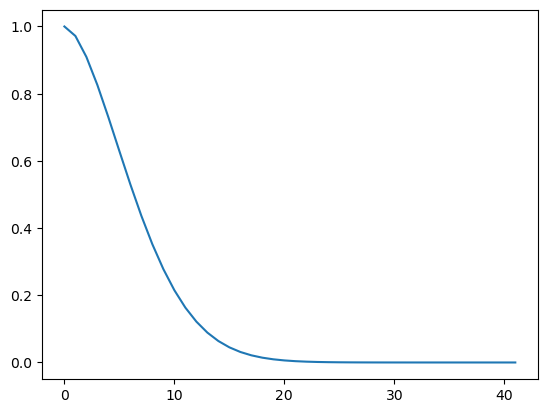

In [31]:
#Define timesteps
time_max = stock_flow_timeseries.shape[0]
timesteps = np.arange(0, time_max)

# Weibull distributed survival curve representative for the Netherlands, Belgium and France (no data available for Ireland)
curve_shape = 1.73
curve_scale = 7.8
curve_surv = scipy.stats.weibull_min.sf(timesteps, curve_shape, 0, curve_scale)

#Visualise the result
plt.plot(curve_surv)

#Define data as float to align with later usage
curve_surv = curve_surv.astype(float)

### 3.3 Initiate normalized survival curve matrix

In [33]:
# create survival curve matrix with placeholder zeros
curve_surv_matrix = pd.DataFrame(0.0, index=timesteps, columns=timesteps)

# populate the survival curve matrix with shifted curves, column by column using slices
for time in timesteps:
    curve_surv_matrix.loc[time:, time] = curve_surv[0:time_max - time]

### 3.4 Populate survival curve matrix with inflow values

In [34]:
# create survival matrix with placeholder zeros
cohort_surv_matrix = pd.DataFrame(0.0, index=timesteps, columns=timesteps)

# multiply the inflow times the shifted curves to get the cohorts' behavior over time

for time in timesteps:
    cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * stock_flow_timeseries['inflow'].iloc[time]

# set row index to years instead of timesteps
cohort_surv_matrix.index = stock_flow_timeseries.index



### 3.5 Calculate stock, net addition to stock (NAS) and Outflow of products

In [ ]:
# calculate flows & stocks using the cohort_surv_matrix
stock_flow_timeseries['stock'] = cohort_surv_matrix.sum(axis=1)
stock_flow_timeseries['nas'] = np.diff(stock_flow_timeseries['stock'], prepend=0)  # prepending 0 assumes no initial stock
stock_flow_timeseries['outflow'] = stock_flow_timeseries['inflow'] - stock_flow_timeseries['nas']

#Visualize calculated flows and stocks
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['nas'], label = 'NAS')
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['inflow'], label = 'Inflow')
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['outflow'], label = 'outflow')
plt.legend()
plt.show()
plt.close()
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['stock'], label = 'stock')

### 3.6 Calculate material content in Inflow, NAS, Outflow and stock

In [ ]:
#Definde steel intensity as function of the inputs to the kettle process production
steel_intensity = 0.3653 #Because significant digits matter

#Calculate material content
steel_stock_flow_timeseries = stock_flow_timeseries*steel_intensity

# Visualize the comparison of the total inflow and the material contents in inflow
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['outflow'], label = 'outflow')
plt.plot(steel_stock_flow_timeseries.index,steel_stock_flow_timeseries['outflow'], label = 'steel outflow')
plt.legend()
plt.show()
plt.close()

### 3.7 Calculate secondary material availablility

In [4]:
# Define static efficiency of steel recycling
steel_recycle_efficiency = 0.784444 #Because significant digits matter

# Calculate the secondary material availability of steel
secondary_steel_stock_flow_timeseries = steel_stock_flow_timeseries*steel_recycle_efficiency

#Visualise the steel outflow vs. the secondary steel outflow
plt.plot(steel_stock_flow_timeseries.index,steel_stock_flow_timeseries['outflow'], label = 'steel outflow')
plt.plot(secondary_steel_stock_flow_timeseries.index,secondary_steel_stock_flow_timeseries['outflow'], label = 'recycled steel')
plt.legend()
plt.show()
plt.close()

#Calculate the relative share of secondary material in the inflow for steel
secondary_steel_share = secondary_steel_stock_flow_timeseries['outflow']/steel_stock_flow_timeseries['inflow']


NameError: name 'steel_stock_flow_timeseries' is not defined

## 4. Integrate the dMFA results with the LCA

### 4.1 Update material composition in kettle year dependend kettle inventory

In [ ]:
def multiply_column_by_value(column, value):
    new_column = column * value
    return new_column.values

def calculate_remaining_fraction_column (column):
    new_column = 1 - column
    return new_column.values
    

In [ ]:
#Create df to store secondary steel values
secondary_steel_df = pd.DataFrame()
secondary_steel_df['years'] = stock_flow_timeseries.index

#Calculate secondary and primary steel share
secondary_steel_df['secondary steel share'] = secondary_steel_share
secondary_steel_df['primary steel share'] = calculate_remaining_fraction_column(secondary_steel_df['secondary steel share'])

#define original value steel
steel_primary_mass = 0.546246

#Call function to calculate new material composition and add to df
secondary_steel_df['updated secondary steel share'] = multiply_column_by_value(secondary_steel_df['secondary steel share'],steel_primary_share)


### 4.2 Calculate year dependend LCIAs of kettle lifecycle

In [145]:
for value in secondary_steel_share_dict.items():
    materials = update_material_composition(value)
    primary_input = list(kettle_production.technosphere())[0]
    secondary_input = list(kettle_production.technosphere())[1]
    
    primary_input['amount'] = materials['slt1']
    primary_input.save()

    secondary_input['amount'] = materials['slt2']
    secondary_input.save()
    

    functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False)
    lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
    lca.lci()


{0: 0.0,
 1: 0.020220549836779397,
 2: 0.06161149056516167,
 3: 0.11355509467297879,
 4: 0.170377011437841,
 5: 0.22814196375824192,
 6: 0.2829506206772885,
 7: 0.335157941012714,
 8: 0.3829996852411873,
 9: 0.42313738081124247,
 10: 0.4542848107441111,
 11: 0.4784623873663422,
 12: 0.4993941220440544,
 13: 0.5175429585542917,
 14: 0.5584639861656617,
 15: 0.578910841440185,
 16: 0.561825376954089,
 17: 0.5453540790036875,
 18: 0.5104838887942497,
 19: 0.4832148924417496,
 20: 0.41238601935039126,
 21: 0.5023036343278511,
 22: 0.4097328453610008,
 23: 0.3567579367381307,
 24: 0.41100125670173093,
 25: 0.4767799601937566,
 26: 0.5477395355049691,
 27: 0.6277708933222904,
 28: 0.762416888980877,
 29: 0.8265113450552737,
 30: 0.8838255311127807,
 31: 0.7299886124713949,
 32: 0.6916730142226925,
 33: 0.6227203861871833,
 34: 0.5428643128657764,
 35: 0.48610717539442433,
 36: 0.535380772415173,
 37: 0.5456493039418815,
 38: 0.5592499659525586,
 39: 0.5752235489911421,
 40: 0.531999545691808

NameError: name 'secondary_steel_share_dict' is not defined

In [159]:
for value in np.array(secondary_steel_share):
    materials = update_material_composition(value)
    primary_input = list(kettle_production.technosphere())[0]
    secondary_input = list(kettle_production.technosphere())[1]
    
    primary_input['amount'] = materials['slt1']
    primary_input.save()

    secondary_input['amount'] = materials['slt2']
    secondary_input.save()
    

    functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False)
    lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
    lca.lci()


2.5236564213757333
2.472626691604546
2.368170106162154
2.2370824295463194
2.0936833566366317
1.947904506354405
1.8095863490083275
1.6778329570721837
1.557096843892026
1.4558030602330518
1.3771977083479214
1.31618169802519
1.2633572217803248
1.2175558700563158
1.1142851803851386
1.062684394917781
1.1058022323516496
1.147370130310705
1.2353704671024843
1.304188082694992
1.482935881836113
1.256014664055101
1.489631449635766
1.623321956120293
1.4864305086292404
1.3204276812822116
1.1413500535889085
0.93937835899645
0.599578121055643
0.43782575178423144
0.2931844348107049
0.6814160130509208
0.7781114042776238
0.952124156910898
1.1536533952092896
1.2968888962884648
1.172539332670624
1.1466250385928447
1.1123016654100866
1.0719898146091538
1.1810723298290213
1.1547508272590363


In [156]:
    
    primary_input['amount'] = materials['slt1']
    primary_input.save()

    secondary_input['amount'] = materials['slt2']
    secondary_input.save()

    functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False)
    lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
    lca.lci()
    lca.inventory[lca.dicts.biosphere[co2.id], :].sum()
    lca.inventory[lca.dicts.biosphere[co2.id], :].sum()

1.4558030602330518

In [117]:
secondary_steel_share_dict

{}

In [ ]:
my_edge['<some_key>'] = "<some_new_value>"
my_edge.save()


lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
lca.lci()
lca.inventory[lca.dicts.biosphere[co2.id], :].sum()

In [102]:
primary_input = list(kettle_production.technosphere())[0]
primary_input

Exchange: 0.546246 kilogram 'steel' (kilogram, GLO, None) to 'kettle production' (None, RER, None)>

In [105]:
secondary_input = list(kettle_production.technosphere())[1]
secondary_input

Exchange: 0 kilogram 'steel2' (kilogram, GLO, None) to 'kettle production' (None, RER, None)>

In [104]:
primary_input['amount'] = 0.5
primary_input.save()
primary_input

Exchange: 0.5 kilogram 'steel' (kilogram, GLO, None) to 'kettle production' (None, RER, None)>

In [106]:
secondary_input['amount'] = 0.1
secondary_input.save()
secondary_input

Exchange: 0.1 kilogram 'steel2' (kilogram, GLO, None) to 'kettle production' (None, RER, None)>

In [107]:
list(kettle_production.technosphere())

[Exchange: 0.5 kilogram 'steel' (kilogram, GLO, None) to 'kettle production' (None, RER, None)>,
 Exchange: 0.1 kilogram 'steel2' (kilogram, GLO, None) to 'kettle production' (None, RER, None)>]

### Old environmental calculations

In [ ]:
functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False)